In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from sklearn import preprocessing
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen

### Iterrows 用法

In [3]:
df = pd.DataFrame({
    'date': [pd.to_datetime('2024-01-01')],  
    '1': [324],  
    '2': [535],
    '3': [235]
})
df.index = pd.to_datetime(df['date'])
df = df.drop(columns = 'date')
df

,1,2,3
date,,,
2024-01-01,324,535,235


In [4]:
# 篩選股價前2大的股票代號
top_50_stocks = []

for date, row in df.iterrows():

    top_50 = row.dropna().nlargest(2)
    top_50_stocks.extend([(date, stock) for stock in top_50.index])

MarketComposition = pd.DataFrame(top_50_stocks, columns=['Date', 'Symbols'])
MarketComposition


,Date,Symbols
0,2024-01-01,2
1,2024-01-01,1


### Clustering using Unsupervised Learning

In [5]:
df = pd.read_csv('close.csv')
df.index = pd.to_datetime(df['date'])
df.sort_index(inplace = True)  # Sort the index of a DataFrame
df = df.drop(columns = 'date')
df = df[df.index.year == 2024].ffill()
df = df.dropna(axis=1, how='any')
df = df.iloc[:,0:20]
df

,0050,0051,0052,0053,0055,0056,0057,0061,006201,006203,006204,006205,006206,006207,006208,00631L,00632R,00633L,00634R,00635U
date,,,,,,,,,,,,,,,,,,,,
2024-01-02,134.90,73.45,128.45,71.25,24.13,37.17,99.25,16.15,19.77,65.90,88.85,27.33,26.14,21.03,76.90,149.95,4.52,28.66,4.99,24.98
2024-01-03,132.55,72.50,125.90,70.10,23.92,36.68,97.70,16.07,19.50,64.75,87.75,27.26,26.10,20.90,75.60,145.90,4.57,28.39,5.04,24.92
2024-01-04,132.50,72.60,125.70,69.65,23.96,36.59,97.50,15.92,19.41,64.75,87.60,27.04,25.79,20.66,75.55,145.70,4.57,27.82,5.09,24.68
2024-01-05,132.15,72.85,125.40,69.55,23.90,36.55,97.40,15.95,19.50,64.65,87.75,27.14,25.99,20.74,75.35,145.15,4.59,28.29,5.04,24.68
2024-01-08,132.75,72.85,126.10,70.20,24.05,36.57,98.00,15.70,19.57,65.05,88.00,26.69,25.58,20.38,75.90,146.35,4.56,27.26,5.14,24.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,183.95,81.60,177.10,97.60,29.35,38.66,134.50,22.80,24.11,86.35,112.90,33.69,32.99,25.88,107.50,228.95,3.40,43.03,3.98,30.69
2024-10-01,183.60,81.60,179.05,98.70,29.25,38.57,136.25,21.17,24.35,87.20,112.90,33.60,32.68,25.85,107.50,230.00,3.40,42.70,4.00,30.58
2024-10-04,183.60,80.30,179.25,98.50,29.05,38.35,135.70,24.53,24.24,87.20,112.30,38.12,36.95,29.00,107.50,228.10,3.41,53.50,3.63,30.88


#### PCA

In [ ]:
### 計算收益率
df_ret = df.pct_change()
df_ret.dropna(axis=0, how='all', inplace=True)  # drop first row (NA)

### 標準化
scaler = preprocessing.StandardScaler()
df_ret_scaled = scaler.fit_transform(df_ret)

### PCA analysis
pca = PCA(n_components=0.5)  # 保留主成分解釋資料的變異%數 or 主成分個數
pca.fit(df_ret_scaled)
X = pca.components_.T  # return data after PCA
pca.n_components_

### 顯示解釋變異比例
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance Ratio')

4

#### OPTICS

In [58]:
### Compute OPTICS
clust = OPTICS(min_samples=5, cluster_method='xi', metric='minkowski').fit(X)
labels = clust.labels_  # 每個數據點的聚類標籤
reachability = clust.reachability_

# no_clusters = len(np.unique(labels[labels != -1]))
# no_noise = np.sum(labels == -1)
# print('Estimated no. of clusters:', no_clusters)
# print('Estimated no. of noise points:', no_noise)
# print('Percentage of noise points: {:.2f}%'.format(no_noise/len(labels)*100))

### Generate reachability plot
# plt.plot(reachability[clust.ordering_])
# plt.title('Reachability plot')
# plt.show()

cluster = np.array([df.columns, labels, reachability]).T[clust.ordering_]
cluster = pd.DataFrame(cluster, columns=['symbols', 'labels', 'reachability'])
cluster.iloc[0, 2] = 0
print(cluster)

avg_reachability = cluster.groupby('labels')['reachability'].mean().sort_values()  # 按照 reachability 排列 labels
print('按照密集程度排序label\n', avg_reachability)

labels_sorted = avg_reachability.index
testlist = []
for label in labels_sorted:
    stock = cluster[cluster['labels'] == label]['symbols'].tolist()
    testlist.append({
        f'{label}' : stock           
    })
print(testlist)
cluster_symbol = list(testlist[0].values())[0]

   symbols labels reachability
0     0050      0            0
1     0052      0     0.050198
2     0053      0     0.050198
3     0057      0     0.050198
4   006203      0     0.049513
5   006208      0     0.044731
6   006204      0     0.127047
7   00631L      0      0.14668
8   006201      0     0.228996
9     0051      0     0.286427
10    0056      0     0.286427
11    0055      0     0.325582
12    0061      1     0.488067
13  006205      1     0.193121
14  006206      1     0.193121
15  006207      1     0.167205
16  00633L      1     0.100995
17  00632R      1     0.505338
18  00634R     -1     0.513976
19  00635U     -1     1.026717
按照密集程度排序label
 labels
 0    0.137166
 1    0.274641
-1    0.770347
Name: reachability, dtype: object
[{'0': ['0050', '0052', '0053', '0057', '006203', '006208', '006204', '00631L', '006201', '0051', '0056', '0055']}, {'1': ['0061', '006205', '006206', '006207', '00633L', '00632R']}, {'-1': ['00634R', '00635U']}]


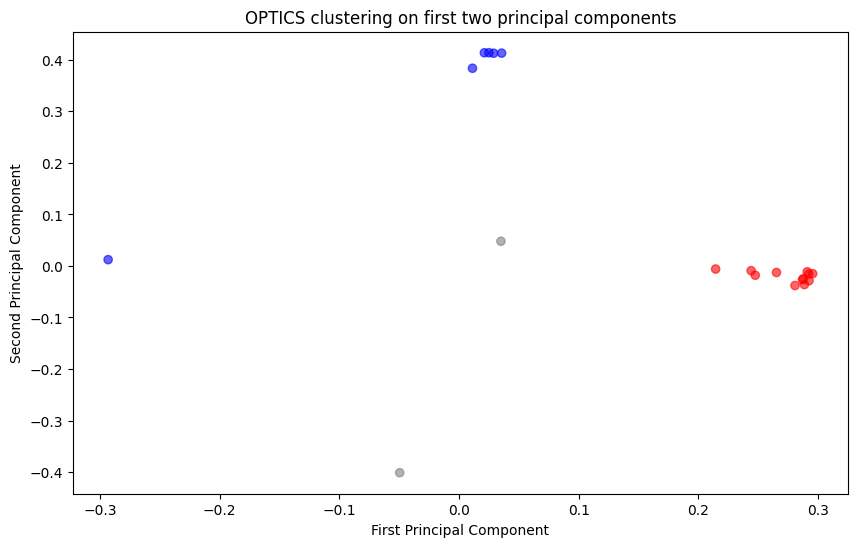

In [ ]:
### 繪製聚類結果
colors = ['red' if x == 0 else 'blue' if x != -1 else '#808080' for x in labels]
plt.figure(figsize=(10, 6))
plt.scatter(X[:,0], X[:,1], c=colors, marker="o", alpha=0.6)
plt.title('OPTICS clustering on first two principal components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

### Johansen's Approch

In [236]:
result = coint_johansen(df.iloc[:,:5], det_order=0, k_ar_diff=1)

In [237]:
print(result.lr2)  # Maximum eigenvalue statistic
print(result.cvm)  # Critical values (90%, 95%, 99%) of maximum eigenvalue statistic.
print(result.cvm[:,1])  # 95% critical values
print(result.lr2 > result.cvm[:,1]) 
print(np.where(result.lr2 > result.cvm[:, 1]))  # np.where(condition)  Returns the "indices" that satisfy the condition.
"""
H_0:rk = r_0  vs.    H_1:rk > r_0
"""
len(np.where(result.lr2 > result.cvm[:, 1])[0])  # Number of cointegrated vectors

[35.46001015 19.52928127  8.91808445  2.91533254  0.54293514]
[[31.2379 33.8777 39.3693]
 [25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
[33.8777 27.5858 21.1314 14.2639  3.8415]
[ True False False False False]
(array([0]),)


1

In [238]:
print(result.evec)  # Eigenvectors of VECM coefficient matrix.
print(result.evec[:, np.where(result.lr2 > result.cvm[:, 1])[0]])  # Cointegrated eigenvectors
# 選出具有共整合關係的共整合向量 (變數的線性組合係數)

[[ 0.57320476  0.25498598  0.6354505  -0.22932055 -0.05692762]
 [ 1.19553134  0.06596194  0.12896724 -0.3914355   0.15323346]
 [ 0.07237192 -0.18546026 -0.20469895  0.21394462  0.52711114]
 [-2.16803852  0.42905148 -0.54407863  0.26276008 -0.92745417]
 [-2.14384202 -3.27895226  0.24337464  0.02756151  0.13654659]]
[[ 0.57320476]
 [ 1.19553134]
 [ 0.07237192]
 [-2.16803852]
 [-2.14384202]]


In [239]:
np.transpose(result.r0t)
r0t = np.transpose(result.r0t)
r1t = np.transpose(result.rkt)
S01 = np.dot(r0t, r1t.T) / r0t.shape[1]
S11 = np.dot(r1t, r1t.T) / r0t.shape[1]
print(S01)

[[-0.72737159 -0.66781308 -1.01015014 -0.61557445 -0.08990984]
 [-0.0945744  -0.3545344  -0.29529543 -0.21190094 -0.0458313 ]
 [-0.63111919 -0.68800397 -1.03511413 -0.62534505 -0.07820762]
 [-0.41577196 -0.49063549 -0.67791622 -0.43491912 -0.05673297]
 [-0.04054265 -0.02900147 -0.04861277 -0.02947424 -0.01369297]]
